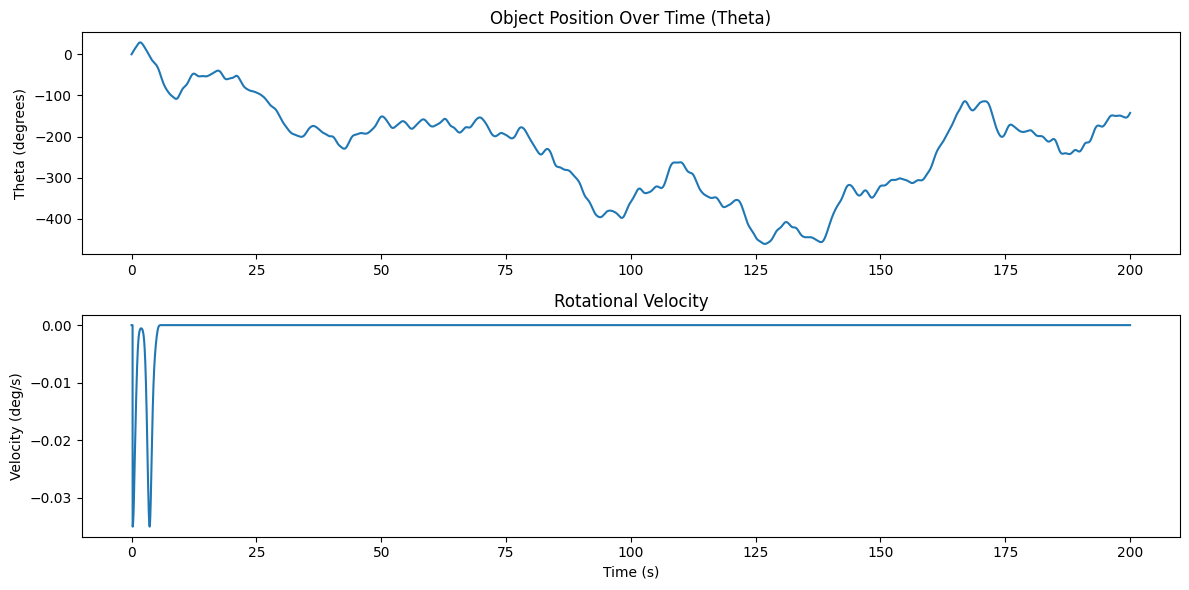

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Simulation parameters
fs = 100  # Hz
T = 200  # seconds
steps = fs * T
delay_steps = int(0.2 * fs)
k = 0.05  # steering gain constant
alpha = 2.0  # noise scaling factor
theta = np.zeros(steps)  # object position over time

# Create smooth random noise to simulate object motion (e.g., female movement)
np.random.seed(0)
raw_noise = np.random.normal(0, 1, steps)
noise = gaussian_filter1d(raw_noise, sigma=fs / 2)
noise *= alpha

# Generate lookup tables for AOTU responses
def aotu025_response(theta):
    return np.exp(-0.5 * ((theta / 30) ** 2))  # wide receptive field

def aotu019_response(theta, direction=0):
    base = np.exp(-0.5 * ((theta / 10) ** 2))  # narrow receptive field
    if direction != 0:
        # Apply direction selectivity
        base *= 1.0 if direction > 0 else 0.3  # reduce response to inward motion
    return base

# Initialize response arrays
r_velocity = np.zeros(steps)
dnas_left = np.zeros(steps)
dnas_right = np.zeros(steps)

# Main simulation loop
for t in range(1, steps):
    th = theta[t - 1]

    # Determine direction of object motion
    direction = np.sign(theta[t - 1] - theta[t - 2]) if t > 1 else 0

    # AOTU responses (mirror symmetry assumed)
    aotu025_r = aotu025_response(th)
    aotu025_l = aotu025_response(-th)
    aotu019_r = aotu019_response(th, direction=-1)
    aotu019_l = aotu019_response(-th, direction=1)

    # Compute DNa02 activity (Eq. 3)
    dnas_right[t] = aotu025_r - aotu019_l
    dnas_left[t] = aotu025_l - aotu019_r

    # Steering command (Eq. 4)
    if t > delay_steps:
        r_velocity[t] = k * (dnas_right[t - delay_steps] - dnas_left[t - delay_steps])
    else:
        r_velocity[t] = 0

    # Update object position (Eq. 5)
    theta[t] = theta[t - 1] - r_velocity[t] + noise[t]

# Display results
time = np.arange(steps) / fs
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, theta)
plt.title("Object Position Over Time (Theta)")
plt.ylabel("Theta (degrees)")

plt.subplot(2, 1, 2)
plt.plot(time, r_velocity)
plt.title("Rotational Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (deg/s)")

plt.tight_layout()
plt.show()
